In [1]:
# Code from 
import torch
import math

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


99 647.3195190429688
199 433.87164306640625
299 291.89764404296875
399 197.42861938476562
499 134.5443115234375
599 92.66761779785156
699 64.76811981201172
799 46.171974182128906
899 33.77084732055664
999 25.496713638305664
1099 19.973148345947266
1199 16.28363800048828
1299 13.817749977111816
1399 12.168638229370117
1499 11.065044403076172
1599 10.3260498046875
1699 9.830831527709961
1799 9.498699188232422
1899 9.275785446166992
1999 9.12606143951416
Result: y = 0.009810985997319221 + 0.8712566494941711 x + -0.0016925580566748977 x^2 + -0.09539513289928436 x^3


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("stock-data.csv")
df.info()
df.drop("Date", inplace=True, axis = 1)
df = df.replace(",","", regex = True)
df = df.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    990 non-null    object 
 1   Open    990 non-null    float64
 2   High    990 non-null    float64
 3   Low     990 non-null    float64
 4   Close   990 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.8+ KB


In [3]:
data = df[["Close"]]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))
print(data.shape)

(990, 1)


/tmp/ipykernel_3462432/2017097845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))


In [5]:
# #we want to remove the decimal places that get added there incoorectly
# features = torch.round(torch.tensor(features, dtype = torch.float64)*100)/100

# #this is beacuse we want a 1D array for our answerers
# target = torch.round(torch.from_numpy(target)*100)/100


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class stockPredictorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(stockPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    #goes through each layer of the neural netwrok and returns an answer depending
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = stockPredictorLSTM(1,25,3,1)

In [7]:
#split training and validation sets manually
dataset = data.values

test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - test_set_size
print(test_set_size)
print(train_set_size)

train = dataset[0:train_set_size,:]
print(train.shape)

test = dataset[train_set_size:,:]
print(test.shape)

198
792
(792, 1)
(198, 1)


In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.25*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 21
x_train, y_train, x_test, y_test = split_data(data, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (727, 20, 1)
y_train.shape =  (727, 1)
x_test.shape =  (242, 20, 1)
y_test.shape =  (242, 1)


In [9]:
x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
print(type(x_train_lstm))

<class 'torch.Tensor'>


In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

epochs = 500
hist = np.zeros(epochs)
for epoch in range(epochs):
    y_train_pred = model.forward(x_train_lstm)

    loss = criterion(y_train_pred, y_train_lstm)
    if (epoch +1) %10 ==0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 9, Loss: 0.05665508657693863
Epoch 19, Loss: 0.018695125356316566
Epoch 29, Loss: 0.007130378391593695
Epoch 39, Loss: 0.005123348906636238
Epoch 49, Loss: 0.004560174886137247
Epoch 59, Loss: 0.00402798131108284
Epoch 69, Loss: 0.003626829944550991
Epoch 79, Loss: 0.003355758497491479
Epoch 89, Loss: 0.003131187055259943
Epoch 99, Loss: 0.0029520364478230476
Epoch 109, Loss: 0.002784810261800885
Epoch 119, Loss: 0.002618268132209778
Epoch 129, Loss: 0.002449187682941556
Epoch 139, Loss: 0.0022752853110432625
Epoch 149, Loss: 0.0020978215616196394
Epoch 159, Loss: 0.0019261367851868272
Epoch 169, Loss: 0.002973806345835328
Epoch 179, Loss: 0.001966155366972089
Epoch 189, Loss: 0.00189211405813694
Epoch 199, Loss: 0.0017701680772006512
Epoch 209, Loss: 0.0017230603843927383
Epoch 219, Loss: 0.0017014419427141547
Epoch 229, Loss: 0.0016922032227739692
Epoch 239, Loss: 0.0016890447586774826
Epoch 249, Loss: 0.0016874364810064435
Epoch 259, Loss: 0.0016860872274264693
Epoch 269, Loss

In [12]:
actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))

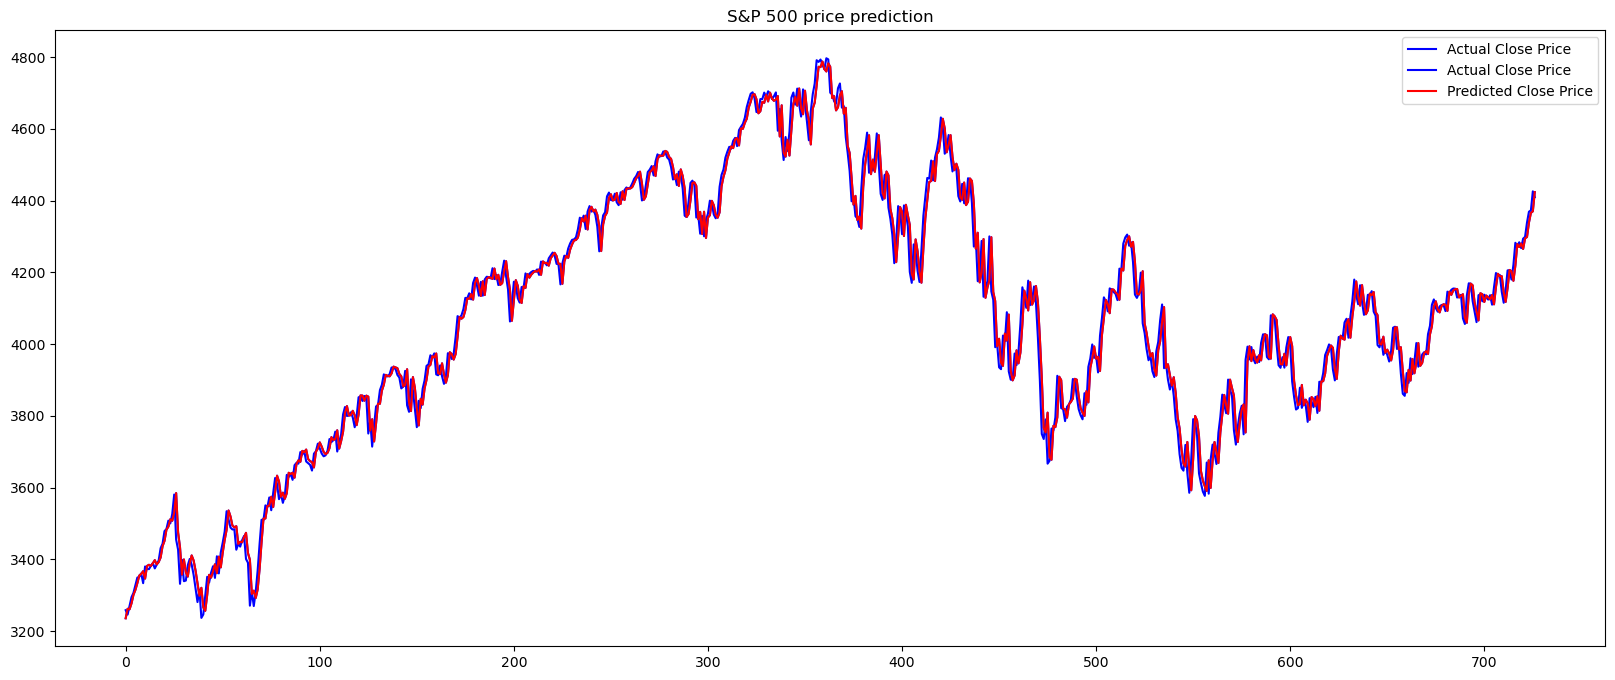

In [13]:
#Plot all predictions
import matplotlib.pyplot as plt

train = data[0:len(actuals)]
valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('S&P 500 price prediction')
plt.legend()
plt.show()

In [14]:
# make predictions
y_test_pred = model(x_test_lstm)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

          actual    predicted
0    4406.377441  4388.709961
1    4390.447754  4365.689941
2    4367.075195  4381.890137
3    4387.265137  4348.330078
4    4348.987793  4328.820312
..           ...          ...
237  5181.871094  5266.949707
238  5166.696777  5235.479980
239  5142.026367  5277.510254
240  5164.972656  5283.399902
241  5157.201660  5291.339844

[242 rows x 2 columns]


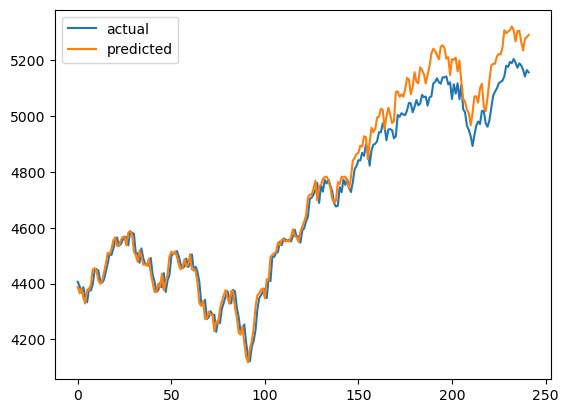

In [15]:
#Shift test predictions for plotting
results_dataframe = pd.concat([pd.DataFrame(y_test_pred), pd.DataFrame(y_test)],axis = 1, ignore_index = True)
results_dataframe.columns =['actual', 'predicted']
print(results_dataframe)

results_dataframe.plot(y=["actual", "predicted"])
plt.show()
